In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>6. Machine Learning Models </h1>
<h2> 6.1 Models with TFIDF-W2V featurization </h2> 

<h3> 6.1.1 Reading data from file</h3>

In [2]:
# read data
data = pd.read_csv("final_features.csv")

In [3]:
data.columns

Index(['Unnamed: 0', 'id', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       ...
       '86_y', '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y',
       '95_y'],
      dtype='object', length=221)

In [4]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [5]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,-148.637857,109.711111,62.538758,72.154383,-137.756539,5.251177,63.611633,-165.109514,-94.521665,25.105438
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,-122.836905,130.318532,44.760436,4.675818,-56.794321,-6.889840,32.630609,-11.958579,-34.432988,28.749938
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,-88.775480,82.716187,-63.615549,-4.947012,-58.495736,-14.816066,100.331751,11.372287,-65.016258,-20.112199
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,17.840809,42.080071,-60.014182,19.771544,-13.976709,8.539354,75.278647,-77.371831,24.389921,-26.920907
5,0.666656,0.571420,0.888879,0.799992,0.705878,0.705878,1.0,0.0,0.0,17.0,...,-161.172379,151.636607,99.466377,90.498715,-51.000550,67.070383,-5.815573,-208.105616,-137.234770,9.813796


<h3> 6.1.2 Converting strings to numerics </h3>

In [9]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [6]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

<h3> 6.1.3 Random train test split( 70:30) </h3>

In [7]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [8]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283002, 218)
Number of data points in test data : (121287, 218)


<h3> 6.1.4 DIstribution of class labels </h3>

In [9]:
#Effect of stratify=y_true
print("Distribution of output variable in train data", "-"*10)
non_zeros = np.count_nonzero(y_train)
train_len = len(y_train)

print("Class 0: {}%, Class 1: {}%".format(np.round((1-int(non_zeros)/train_len)*100,2), np.round(int(non_zeros)/train_len*100,2)))
print()


print("Distribution of output variable in test data", "-"*10)
non_zeros = np.count_nonzero(y_test)
test_len = len(y_test)

print("Class 0: {}%, Class 1: {}%".format(np.round((1-int(non_zeros)/test_len)*100,2), np.round(int(non_zeros)/test_len*100,2)))
print()

Distribution of output variable in train data ----------
Class 0: 63.08%, Class 1: 36.92%

Distribution of output variable in test data ----------
Class 0: 63.08%, Class 1: 36.92%



<h3> 6.1.5  Function for performance metrics </h3> 

In [2]:
# This function plots the confusion matrices given y_i, y_i_hat.


def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    
    # divide each element of the confusion matrix with the sum of elements in that column
    B =(C/C.sum(axis=0))
    
    # divide each element of the confusion matrix with the sum of elements in that row
    plt.figure(figsize=(20,4))
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("maroon")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h3> 6.1.6 Building a random model (Finding worst-case log-loss) </h3>

Log loss on Test Data using Random Model 0.8869227272755311


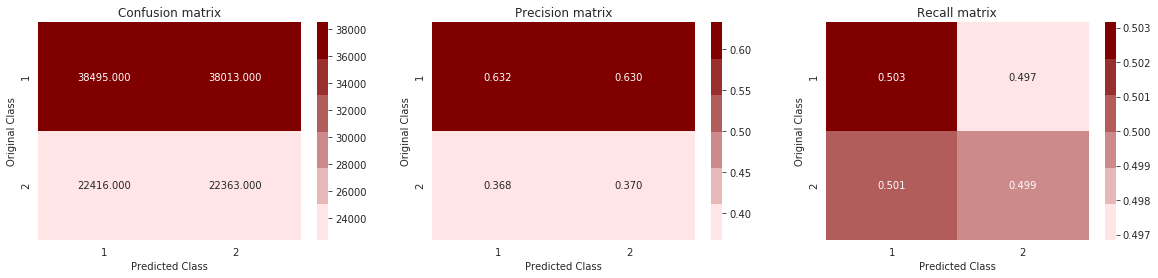

In [16]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h3> 6.1.7 Logistic Regression with hyperparameter tuning </h3>

For values of alpha =  1e-05 The log loss is: 0.46216028108733154
For values of alpha =  0.0001 The log loss is: 0.4518262105614325
For values of alpha =  0.001 The log loss is: 0.44380576402872535
For values of alpha =  0.01 The log loss is: 0.436653999333274
For values of alpha =  0.1 The log loss is: 0.4510129156695386
For values of alpha =  1 The log loss is: 0.48219784207532823
For values of alpha =  10 The log loss is: 0.5275336388968793


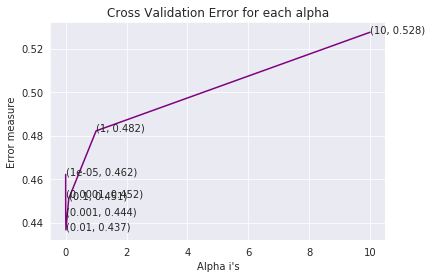

For values of best alpha =  0.01 The train log loss is: 0.4362397763406863
For values of best alpha =  0.01 The test log loss is: 0.436653999333274
Total number of data points : 121287


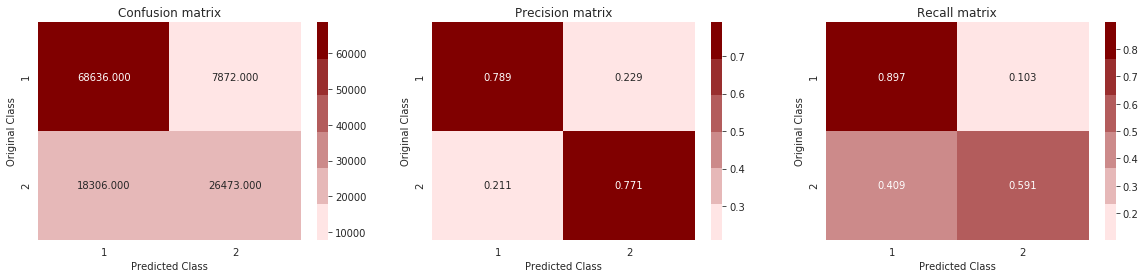

CPU times: user 52min 54s, sys: 2min 45s, total: 55min 39s
Wall time: 50min 27s


In [13]:
%%time

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='purple')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h3> 6.1.8 XGBoost </h3>

In [15]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68494	valid-logloss:0.68485
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61573	valid-logloss:0.61563
[20]	train-logloss:0.56505	valid-logloss:0.56486
[30]	train-logloss:0.52719	valid-logloss:0.52683
[40]	train-logloss:0.49822	valid-logloss:0.49777
[50]	train-logloss:0.47511	valid-logloss:0.47459
[60]	train-logloss:0.45667	valid-logloss:0.45614
[70]	train-logloss:0.44192	valid-logloss:0.44131
[80]	train-logloss:0.43004	valid-logloss:0.42937
[90]	train-logloss:0.42038	valid-logloss:0.41969
[100]	train-logloss:0.41245	valid-logloss:0.41170
[110]	train-logloss:0.40569	valid-logloss:0.40488
[120]	train-logloss:0.40010	valid-logloss:0.39929
[130]	train-logloss:0.39534	valid-logloss:0.39449
[140]	train-logloss:0.39145	valid-logloss:0.39058
[150]	train-logloss:0.38778	valid-logloss:0.38689
[160]	train-logloss:0.38486	valid-logloss:0.38397
[170]	trai

Total number of data points : 121287


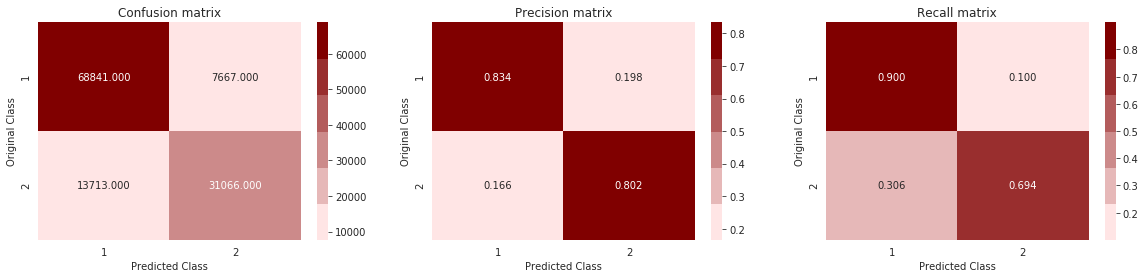

In [16]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h3> 6.1.9 XGBoost with hyperparameter tuning with optuna</h3>

In [11]:
%%time
import optuna
import xgboost as xgb

def objective(trial):
    params = {'objective': 'binary:logistic', 
              'eval_metric': 'logloss', 
              'max_depth': trial.suggest_int('max_depth', 4, 8),
              'gamma' : trial.suggest_discrete_uniform('gamma', 0.2, 0.75, 0.2),
              'min_child_weight': trial.suggest_int('min_child_weight', 5, 10), 
              'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1), 
              'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
             }
    earlyStop=20
    
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_test, label=y_test)
    
    watchlist = [(d_train, 'train'), (d_test, 'valid')]
    model = xgb.train(params, d_train, 1200, watchlist, early_stopping_rounds=earlyStop, verbose_eval=10)
    pred = model.predict
    xgdmat = xgb.DMatrix(X_train,y_train)
    predict_y = model.predict(d_test)
    loss = log_loss(y_test, predict_y, labels=[0, 1], eps=1e-15)
    return loss
    

study = optuna.create_study()
study.optimize(objective,n_trials=10)
    

[0]	train-logloss:0.59027	valid-logloss:0.59018
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.37244	valid-logloss:0.37317
[20]	train-logloss:0.34958	valid-logloss:0.35209
[30]	train-logloss:0.33710	valid-logloss:0.34262
[40]	train-logloss:0.32941	valid-logloss:0.33793
[50]	train-logloss:0.32331	valid-logloss:0.33479
[60]	train-logloss:0.31872	valid-logloss:0.33249
[70]	train-logloss:0.31427	valid-logloss:0.33079
[80]	train-logloss:0.31106	valid-logloss:0.32981
[90]	train-logloss:0.30654	valid-logloss:0.32830
[100]	train-logloss:0.30364	valid-logloss:0.32775
[110]	train-logloss:0.30056	valid-logloss:0.32718
[120]	train-logloss:0.29813	valid-logloss:0.32690
[130]	train-logloss:0.29534	valid-logloss:0.32639
[140]	train-logloss:0.29339	valid-logloss:0.32627
[150]	train-logloss:0.29066	valid-logloss:0.32582
[160]	train-logloss:0.28824	valid-logloss:0.32553
[170]	trai

[I 2020-07-19 08:36:24,528] Finished trial#0 with value: 0.32219829953282386 with parameters: {'min_child_weight': 6, 'gamma': 0.2, 'subsample': 0.9, 'max_depth': 5, 'colsample_bytree': 0.7}. Best is trial#0 with value: 0.32219829953282386.


[0]	train-logloss:0.57785	valid-logloss:0.57859
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.34213	valid-logloss:0.35185
[20]	train-logloss:0.31966	valid-logloss:0.33759
[30]	train-logloss:0.30225	valid-logloss:0.33228
[40]	train-logloss:0.28854	valid-logloss:0.33051
[50]	train-logloss:0.27697	valid-logloss:0.32977
[60]	train-logloss:0.26688	valid-logloss:0.32958
[70]	train-logloss:0.25744	valid-logloss:0.32930
[80]	train-logloss:0.25023	valid-logloss:0.32954
[90]	train-logloss:0.24087	valid-logloss:0.33054
Stopping. Best iteration:
[70]	train-logloss:0.25744	valid-logloss:0.32930



[I 2020-07-19 08:39:42,221] Finished trial#1 with value: 0.3305464897670599 with parameters: {'min_child_weight': 10, 'gamma': 0.4, 'subsample': 0.6, 'max_depth': 8, 'colsample_bytree': 0.8}. Best is trial#0 with value: 0.32219829953282386.


[0]	train-logloss:0.58443	valid-logloss:0.58456
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.36162	valid-logloss:0.36363
[20]	train-logloss:0.34168	valid-logloss:0.34699
[30]	train-logloss:0.32842	valid-logloss:0.33825
[40]	train-logloss:0.31940	valid-logloss:0.33443
[50]	train-logloss:0.31281	valid-logloss:0.33296
[60]	train-logloss:0.30753	valid-logloss:0.33202
[70]	train-logloss:0.30225	valid-logloss:0.33147
[80]	train-logloss:0.29693	valid-logloss:0.33131
[90]	train-logloss:0.29259	valid-logloss:0.33075
[100]	train-logloss:0.28775	valid-logloss:0.33056
[110]	train-logloss:0.28306	valid-logloss:0.33016
[120]	train-logloss:0.27943	valid-logloss:0.33000
[130]	train-logloss:0.27619	valid-logloss:0.33016
Stopping. Best iteration:
[112]	train-logloss:0.28204	valid-logloss:0.32995



[I 2020-07-19 08:43:04,606] Finished trial#2 with value: 0.330173128943831 with parameters: {'min_child_weight': 8, 'gamma': 0.4, 'subsample': 0.5, 'max_depth': 6, 'colsample_bytree': 0.8}. Best is trial#0 with value: 0.32219829953282386.


[0]	train-logloss:0.58696	valid-logloss:0.58671
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.36475	valid-logloss:0.36643
[20]	train-logloss:0.34097	valid-logloss:0.34637
[30]	train-logloss:0.32839	valid-logloss:0.33807
[40]	train-logloss:0.31930	valid-logloss:0.33407
[50]	train-logloss:0.31194	valid-logloss:0.33162
[60]	train-logloss:0.30527	valid-logloss:0.32989
[70]	train-logloss:0.30001	valid-logloss:0.32899
[80]	train-logloss:0.29604	valid-logloss:0.32790
[90]	train-logloss:0.29162	valid-logloss:0.32719
[100]	train-logloss:0.28780	valid-logloss:0.32693
[110]	train-logloss:0.28377	valid-logloss:0.32675
[120]	train-logloss:0.27938	valid-logloss:0.32637
[130]	train-logloss:0.27575	valid-logloss:0.32638
[140]	train-logloss:0.27240	valid-logloss:0.32631
[150]	train-logloss:0.26924	valid-logloss:0.32633
[160]	train-logloss:0.26632	valid-logloss:0.32613
[170]	trai

[I 2020-07-19 08:46:13,225] Finished trial#3 with value: 0.3265646363664178 with parameters: {'min_child_weight': 7, 'gamma': 0.2, 'subsample': 0.6, 'max_depth': 6, 'colsample_bytree': 0.5}. Best is trial#0 with value: 0.32219829953282386.


[0]	train-logloss:0.58122	valid-logloss:0.58144
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.35004	valid-logloss:0.35595
[20]	train-logloss:0.32809	valid-logloss:0.34030
[30]	train-logloss:0.31315	valid-logloss:0.33385
[40]	train-logloss:0.30220	valid-logloss:0.33061
[50]	train-logloss:0.29376	valid-logloss:0.32873
[60]	train-logloss:0.28590	valid-logloss:0.32782
[70]	train-logloss:0.27761	valid-logloss:0.32677
[80]	train-logloss:0.26939	valid-logloss:0.32617
[90]	train-logloss:0.26220	valid-logloss:0.32573
[100]	train-logloss:0.25663	valid-logloss:0.32567
[110]	train-logloss:0.24966	valid-logloss:0.32555
Stopping. Best iteration:
[96]	train-logloss:0.25940	valid-logloss:0.32551



[I 2020-07-19 08:49:47,783] Finished trial#4 with value: 0.32557535367226165 with parameters: {'min_child_weight': 6, 'gamma': 0.2, 'subsample': 0.8, 'max_depth': 7, 'colsample_bytree': 0.7}. Best is trial#0 with value: 0.32219829953282386.


[0]	train-logloss:0.58040	valid-logloss:0.58129
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.34480	valid-logloss:0.35575
[20]	train-logloss:0.31571	valid-logloss:0.33766
[30]	train-logloss:0.29944	valid-logloss:0.33307
[40]	train-logloss:0.28544	valid-logloss:0.33087
[50]	train-logloss:0.27351	valid-logloss:0.32977
[60]	train-logloss:0.26285	valid-logloss:0.32909
[70]	train-logloss:0.25333	valid-logloss:0.32905
[80]	train-logloss:0.24247	valid-logloss:0.32933
Stopping. Best iteration:
[68]	train-logloss:0.25634	valid-logloss:0.32899



[I 2020-07-19 08:52:03,847] Finished trial#5 with value: 0.32930828964297837 with parameters: {'min_child_weight': 6, 'gamma': 0.4, 'subsample': 0.7, 'max_depth': 8, 'colsample_bytree': 0.5}. Best is trial#0 with value: 0.32219829953282386.


[0]	train-logloss:0.56415	valid-logloss:0.56488
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.34154	valid-logloss:0.35210
[20]	train-logloss:0.31642	valid-logloss:0.33704
[30]	train-logloss:0.29763	valid-logloss:0.33158
[40]	train-logloss:0.28362	valid-logloss:0.32974
[50]	train-logloss:0.27173	valid-logloss:0.32850
[60]	train-logloss:0.25904	valid-logloss:0.32836
[70]	train-logloss:0.24797	valid-logloss:0.32828
Stopping. Best iteration:
[55]	train-logloss:0.26561	valid-logloss:0.32808



[I 2020-07-19 08:55:17,298] Finished trial#6 with value: 0.3284611993400385 with parameters: {'min_child_weight': 7, 'gamma': 0.6, 'subsample': 0.7, 'max_depth': 8, 'colsample_bytree': 0.9}. Best is trial#0 with value: 0.32219829953282386.


[0]	train-logloss:0.58040	valid-logloss:0.58124
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.34194	valid-logloss:0.35296
[20]	train-logloss:0.31668	valid-logloss:0.33726
[30]	train-logloss:0.29934	valid-logloss:0.33196
[40]	train-logloss:0.28608	valid-logloss:0.32967
[50]	train-logloss:0.27338	valid-logloss:0.32893
[60]	train-logloss:0.26133	valid-logloss:0.32907
[70]	train-logloss:0.25327	valid-logloss:0.32882
[80]	train-logloss:0.24302	valid-logloss:0.32851
[90]	train-logloss:0.23511	valid-logloss:0.32847
[100]	train-logloss:0.22760	valid-logloss:0.32846
[110]	train-logloss:0.22031	valid-logloss:0.32862
[120]	train-logloss:0.21160	valid-logloss:0.32898
Stopping. Best iteration:
[104]	train-logloss:0.22459	valid-logloss:0.32828



[I 2020-07-19 08:58:55,561] Finished trial#7 with value: 0.3289537279849021 with parameters: {'min_child_weight': 6, 'gamma': 0.2, 'subsample': 0.7, 'max_depth': 8, 'colsample_bytree': 0.6}. Best is trial#0 with value: 0.32219829953282386.


[0]	train-logloss:0.56801	valid-logloss:0.56841
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.35095	valid-logloss:0.35653
[20]	train-logloss:0.32887	valid-logloss:0.34008
[30]	train-logloss:0.31550	valid-logloss:0.33469
[40]	train-logloss:0.30447	valid-logloss:0.33152
[50]	train-logloss:0.29527	valid-logloss:0.32982
[60]	train-logloss:0.28657	valid-logloss:0.32898
[70]	train-logloss:0.28051	valid-logloss:0.32887
[80]	train-logloss:0.27346	valid-logloss:0.32856
[90]	train-logloss:0.26623	valid-logloss:0.32841
[100]	train-logloss:0.25986	valid-logloss:0.32855
Stopping. Best iteration:
[83]	train-logloss:0.27088	valid-logloss:0.32825



[I 2020-07-19 09:02:33,682] Finished trial#8 with value: 0.3284522895429652 with parameters: {'min_child_weight': 9, 'gamma': 0.6, 'subsample': 0.6, 'max_depth': 7, 'colsample_bytree': 0.9}. Best is trial#0 with value: 0.32219829953282386.


[0]	train-logloss:0.59062	valid-logloss:0.59054
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.37070	valid-logloss:0.37187
[20]	train-logloss:0.34970	valid-logloss:0.35246
[30]	train-logloss:0.33770	valid-logloss:0.34318
[40]	train-logloss:0.33039	valid-logloss:0.33854
[50]	train-logloss:0.32522	valid-logloss:0.33623
[60]	train-logloss:0.31945	valid-logloss:0.33306
[70]	train-logloss:0.31506	valid-logloss:0.33149
[80]	train-logloss:0.31150	valid-logloss:0.33059
[90]	train-logloss:0.30725	valid-logloss:0.32954
[100]	train-logloss:0.30480	valid-logloss:0.32909
[110]	train-logloss:0.30131	valid-logloss:0.32799
[120]	train-logloss:0.29759	valid-logloss:0.32710
[130]	train-logloss:0.29448	valid-logloss:0.32678
[140]	train-logloss:0.29191	valid-logloss:0.32659
[150]	train-logloss:0.28929	valid-logloss:0.32624
[160]	train-logloss:0.28668	valid-logloss:0.32614
[170]	trai

[I 2020-07-19 09:09:09,974] Finished trial#9 with value: 0.3240531194865497 with parameters: {'min_child_weight': 5, 'gamma': 0.2, 'subsample': 0.8, 'max_depth': 5, 'colsample_bytree': 0.7}. Best is trial#0 with value: 0.32219829953282386.


CPU times: user 5h 8min 57s, sys: 18.7 s, total: 5h 9min 16s
Wall time: 40min 9s


In [12]:
dt_hyperparam = study.trials_dataframe()
dt_hyperparam

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_max_depth,params_min_child_weight,params_subsample,state
0,0,0.322198,2020-07-19 08:29:05.318001,2020-07-19 08:36:24.528453,00:07:19.210452,0.7,0.2,5,6,0.9,COMPLETE
1,1,0.330546,2020-07-19 08:36:24.532360,2020-07-19 08:39:42.220595,00:03:17.688235,0.8,0.4,8,10,0.6,COMPLETE
2,2,0.330173,2020-07-19 08:39:42.224669,2020-07-19 08:43:04.605849,00:03:22.381180,0.8,0.4,6,8,0.5,COMPLETE
3,3,0.326565,2020-07-19 08:43:04.609251,2020-07-19 08:46:13.224682,00:03:08.615431,0.5,0.2,6,7,0.6,COMPLETE
4,4,0.325575,2020-07-19 08:46:13.227984,2020-07-19 08:49:47.782904,00:03:34.554920,0.7,0.2,7,6,0.8,COMPLETE
5,5,0.329308,2020-07-19 08:49:47.786215,2020-07-19 08:52:03.846687,00:02:16.060472,0.5,0.4,8,6,0.7,COMPLETE
6,6,0.328461,2020-07-19 08:52:03.850496,2020-07-19 08:55:17.297664,00:03:13.447168,0.9,0.6,8,7,0.7,COMPLETE
7,7,0.328954,2020-07-19 08:55:17.300924,2020-07-19 08:58:55.560916,00:03:38.259992,0.6,0.2,8,6,0.7,COMPLETE
8,8,0.328452,2020-07-19 08:58:55.564176,2020-07-19 09:02:33.682094,00:03:38.117918,0.9,0.6,7,9,0.6,COMPLETE
9,9,0.324053,2020-07-19 09:02:33.686516,2020-07-19 09:09:09.973993,00:06:36.287477,0.7,0.2,5,5,0.8,COMPLETE


<h4> Best parameters and best trial value </h4>

In [13]:
best_params = study.best_trial.params
best_trial_val = study.best_trial.value
print(best_trial_val)
print(best_params)

0.32219829953282386
{'min_child_weight': 6, 'gamma': 0.2, 'subsample': 0.9, 'max_depth': 5, 'colsample_bytree': 0.7}


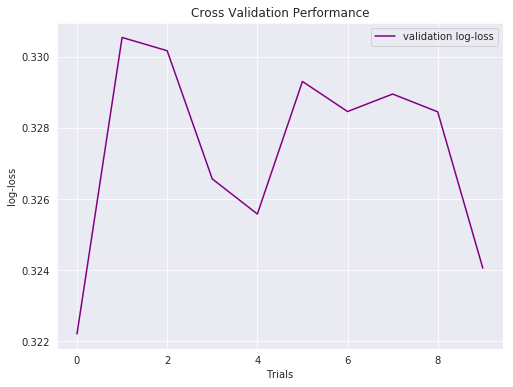

In [17]:
sns.set_style('darkgrid')
x_ax = np.array(dt_hyperparam['number'])
y_ax = np.array(dt_hyperparam['value'])
plt.figure(figsize = (8, 6))
sns.lineplot(x_ax, y_ax, color='purple', label = 'validation log-loss')
plt.title("Cross Validation Performance")
plt.xlabel("Trials")
plt.ylabel("log-loss")
plt.legend()
plt.show()


[0]	train-logloss:0.59027	validation-logloss:0.59018
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.37244	validation-logloss:0.37317
[20]	train-logloss:0.34958	validation-logloss:0.35209
[30]	train-logloss:0.33710	validation-logloss:0.34262
[40]	train-logloss:0.32941	validation-logloss:0.33793
[50]	train-logloss:0.32331	validation-logloss:0.33479
[60]	train-logloss:0.31872	validation-logloss:0.33249
[70]	train-logloss:0.31427	validation-logloss:0.33079
[80]	train-logloss:0.31106	validation-logloss:0.32981
[90]	train-logloss:0.30654	validation-logloss:0.32830
[100]	train-logloss:0.30364	validation-logloss:0.32775
[110]	train-logloss:0.30056	validation-logloss:0.32718
[120]	train-logloss:0.29813	validation-logloss:0.32690
[130]	train-logloss:0.29534	validation-logloss:0.32639
[140]	train-logloss:0.29339	validation-logloss:0.32627
[150]	train-logloss:0.290

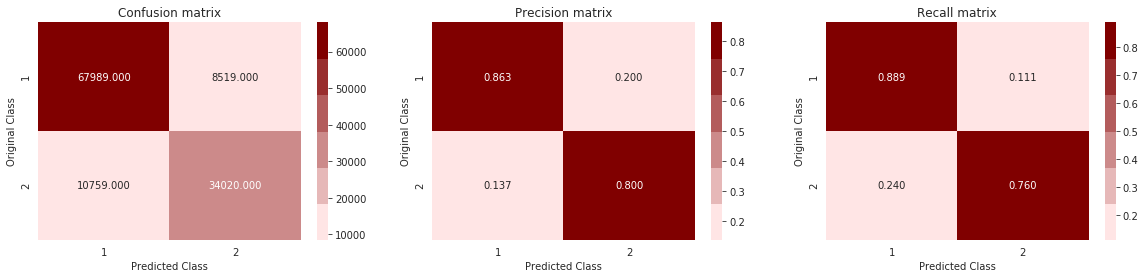

In [16]:
params = {'objective': 'binary:logistic', 
              'eval_metric': 'logloss', 
              'max_depth': 5, 
              'min_child_weight': 6, 
              'gamma': 0.2,
              'subsample': 0.9, 
              'colsample_bytree': 0.7
             }
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'validation')]
bst = xgb.train(params, d_train, 1200, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("\nThe train log loss is:",log_loss(y_train, bst.predict(d_train), labels=[0, 1], eps=1e-15))
print("\nThe test log loss is:",log_loss(y_test, predict_y, labels=[0, 1], eps=1e-15))

predicted_y =np.array(predict_y>0.5,dtype=int)
print("\nTotal number of validation data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 6.2 Models with TFIDF featurization </h2> 

In [3]:
#Load the TFIDF sparse matrices.
import pickle
with open('X_train_TFIDF.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_TFIDF.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_TFIDF.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_TFIDF.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
print("Dimensions of train and test data:")
print("X_train:",X_train.shape, "y_train :",y_train.shape)
print("X_test:",X_test.shape, "y_test :",y_test.shape)

Dimensions of train and test data:
X_train: (283003, 147146) y_train : (283003, 1)
X_test: (121287, 147146) y_test : (121287, 1)


<h3> 6.2.1 XGBoost </h3>

[0]	train-logloss:0.68370	validation-logloss:0.68369
Multiple eval metrics have been passed: 'validation-logloss' will be used for early stopping.

Will train until validation-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.60472	validation-logloss:0.60534
[20]	train-logloss:0.54652	validation-logloss:0.54766
[30]	train-logloss:0.50292	validation-logloss:0.50456
[40]	train-logloss:0.46929	validation-logloss:0.47142
[50]	train-logloss:0.44333	validation-logloss:0.44594
[60]	train-logloss:0.42308	validation-logloss:0.42613
[70]	train-logloss:0.40671	validation-logloss:0.41019
[80]	train-logloss:0.39322	validation-logloss:0.39718
[90]	train-logloss:0.38237	validation-logloss:0.38672
[100]	train-logloss:0.37335	validation-logloss:0.37809
[110]	train-logloss:0.36611	validation-logloss:0.37121
[120]	train-logloss:0.36015	validation-logloss:0.36561
[130]	train-logloss:0.35503	validation-logloss:0.36084
[140]	train-logloss:0.35066	validation-logloss:0.35681
[150]	train-logloss:0.346

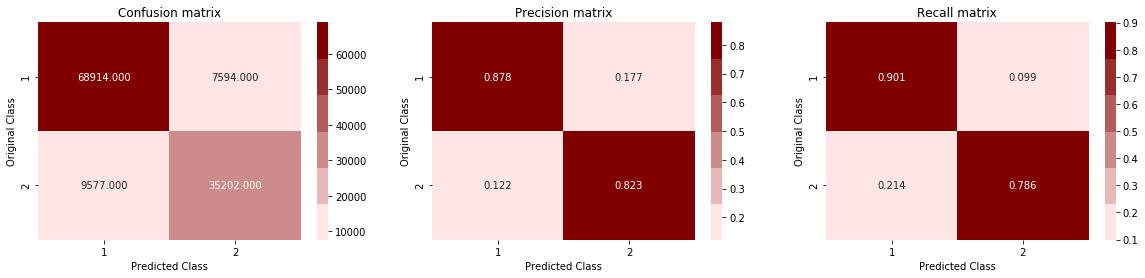

CPU times: user 3h 30min 17s, sys: 6.53 s, total: 3h 30min 24s
Wall time: 1h 3min 34s


In [4]:
%%time

import xgboost as xgb
params = {'objective': 'binary:logistic', 
          'eval_metric': 'logloss', 
          'eta': 0.02, 
          'max_depth': 8, 
          'subsample': 0.6,  
          'min_child_weight': 8, 
          'gamma': 0.25, 
          'colsample_bytree': 0.7, 
         }

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'validation')]

bst = xgb.train(params, d_train, 4000, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("\nThe test log loss is:",log_loss(y_test, predict_y, labels=[0, 1], eps=1e-15))

predicted_y =np.array(predict_y> 0.5, dtype=int)
print("\nTotal number of validation data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h1>7. Compairing perfotmance of all the machine learning models </h1>

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from prettytable import PrettyTable


table = PrettyTable()

table.field_names = ["Model", "Vectorizer", "Log Loss", "Class 0 Precision", "Class 1 Precision","Class 0 Recall","Class 1 Recall"]
table.add_row(["Random Model",'Weighted TFIDF W2V', 0.8869, 0.632, 0.370, 0.503, 0.499])
table.add_row(["SGDClassifier(loss='log')",'Weighted TFIDF W2V', 0.4366, 0.789, 0.771, 0.897, 0.591])
table.add_row(["XGBoost (hyp tuned with Optuna)",'Weighted TFIDF W2V', 0.3222, 0.863, 0.800, 0.889, 0.760])
table.add_row(["XGBoost",'TF-IDF ', 0.2958, 0.878, 0.823, 0.901,0.786])

print(table)

+---------------------------------+--------------------+----------+-------------------+-------------------+----------------+----------------+
|              Model              |     Vectorizer     | Log Loss | Class 0 Precision | Class 1 Precision | Class 0 Recall | Class 1 Recall |
+---------------------------------+--------------------+----------+-------------------+-------------------+----------------+----------------+
|           Random Model          | Weighted TFIDF W2V |  0.8869  |       0.632       |        0.37       |     0.503      |     0.499      |
|    SGDClassifier(loss='log')    | Weighted TFIDF W2V |  0.4366  |       0.789       |       0.771       |     0.897      |     0.591      |
| XGBoost (hyp tuned with Optuna) | Weighted TFIDF W2V |  0.3222  |       0.863       |        0.8        |     0.889      |      0.76      |
|             XGBoost             |      TF-IDF        |  0.2958  |       0.878       |       0.823       |     0.901      |     0.786      |
+-----

## Conclusion: 

The main objective of this Case Study is to classify a new question on Quora as either a duplicate of an existing question or not. Each day thousands of questions are asked on Quora. So there's bound to be questions that are duplicates. Imagine two people asking two differently worded questions which basically have the same meaning and hence the same answer. In this case if two questions are classified as duplicates of one another, using this flag, both the questions can be linked to the same set of answers. If they were not classified as duplicates of each other, then there would be seperate answers for each of these questions. This is not the ideal scenario. Because, ideally we would want the system to pick up duplicate questions and assign answers to a new duplicate question which has been answered for an earlier question. So having said that, the main objective of this experiment was to build an intelligent system which can classify new questions to be duplicate or not of all the existing questions.

For the given task, we are provided with a dataset which contains almost 400K sample pairs of questions. Each of these data points has a label 'is_duplicate'. 'is_duplicate' = 0, if the pairs of questions are not duplicate of one another. 'is_duplicate' = 1, if the pair of questions are duplicates! The problem that we have is a binary classification problem, since, for a given pair of question have to predict either 'is_duplicate' equal to 0 or 1. The metric that we will chose for this problem is 'log loss'. We will also use a binary confusion, precision and recall matrices to get more crisp ideas about individual classes. 

Few things to keep in mind:

1. The cost of misclassification is very very high: Imagine if we wrongly tag a question to be duplicate of another question, the user might be redirected to the answer page that is not meant for the new question that he has asked. This wil absolutely hinder user experience!

2. Idealy, we would want a probability value (P) of Q1 being similar to Q2. We can now set a threshold like if P > 0.95, then we will classify the questions to be duplicate of one another. After getting the probability scores, we can experiment with different values of P. For example we can try with P=0.95. If we are satisfied with the result then it's fine. If not, we can always go ahead and increase the threshold to 0.99 in order to avoid misclassification. 


Why have we chosen our metric to be 'log loss' ?

As we have discussed above, we will use our Key Performance Indicator to be 'log' loss. Minimising the Log Loss is basically equivalent to maximising the accuracy of the classifier. In order to calculate Log loss, the classifier must actually assign a probability value for each of the class labels. Ideally as the predicted class probabilities improve, the Log loss keeps on reducing. Log loss penalises the classifier very heavily if it classifies a Class 0 to be Class 1 and vice versa.  For example, if for a particular observation, the classifier assigns a very small probability to the correct class then the corresponding contribution to the Log Loss will be very large. Naturally this is going to have a significant impact on the overall Log Loss for the classifier,which will then become higher. But, in other scenario if the classifier assigns a high probability value to the correct class, then the Log loss will reduce significantly. Now, imagine a scenario where the model doesn't predict probability scores. It only predicts class labels. In this case, class labels can be either 0 or 1. So we won't get a deep understanding or any interpretability about why a particular pair of question has been labeled as either 0 or 1. Chosing the KPI as Log loss gives us this freedom. We can interpret the models. We can say this two questions are 95% similar or 80% similar, instead of just bluntly classifying them as duplicates.

For deep understanding of log loss please visit: https://datawookie.netlify.com/blog/2015/12/making-sense-of-logarithmic-loss/

Anyway, lets move on to EDA. A high level overview reveals that there are almost 250K question pairs that aren't duplicates and almost 150K question pairs are duplicates. Also, there are a total of 537933 unique questions out of which 111780 of questions occurs more than once. The maximum number of times any question is repeated across the entire data is 157. Thankfully, there are no duplicate pairs of questions. 

Before the data cleaning stage, we have done some basic feature engineering. For more information please refer to section 3.3. On analysing our 'word_share' feature we have seen that the two classes are partially seperable with some overlap. In general, as the 'word_share' count increases, the probability of any pair of questions to be duplicates also increases. This suggest that 'word_share' might be an important feature as far as this problem is concerned. The feature 'word_Common' might not be hugely important, as there is a lot of overlap between the classes. 

Also, I have used Decision Trees to determine the most important features out of all the 26 hand crafter features we have extracted from the text data.

We have removed HTML tags from each of the questions, removed all the punctuations, stopwords. We have expanded themost commonly used English contractions for each questions. We have also performed Stemming using SnowBall stemmer. 

After performing data cleaning, we have extracted some advance features. The four most important amongst them are - fuzz_ratio, fuzz_partial_ratio, token_sort_ratio, token_set_ratio and longest_substring_ratio. Go to section 3.5 for further details. On plotting the word cloud we have observed that 16110763 words are there in all the questions belonging to duplicate questions and almost 33201102 are there in the non duplicate pairs.

We have used these advance features to plot a TSNE plot. By looking at the plot, we can clearly see that the two classes can be seperated nicely, with some overlapping. This suggests that the advance features are useful in some ways.  

Now that we have extracted our basic and advance features, it's time for us to featurize the text in questions. We will use two approach here - using simple TFIDF Features and using TFIDF Weighted Word2Vec representations. We will combine all the features we have obtained into one single data frame and apply Machine Learning models on top of it.

Before building our models, the first thing we need to do is to build a baseline (random) model. Why this is done? Well, we have selected our KPI to be log loss. We all know that the minimum value of log loss is 0, but the maximum value goes till infinity! So we want to determine using a random model what our worst case log loss will be. In a random model - for every data point we generate the predicted class labels randomly. This is the most dumb model we can ever build. The log loss for this model is 0.88. So using this value we will clearly get an idea what out worst case log loss should be! Now using ML models, we will try and reduce this log loss and bring it as close to 0 as possible. 


The models we have used are Logistic Regression with SGDClassifier, Linear SVM with SGD Classifier, a simple Logistic Regression model and XGBoost model. Amongst all the featurizations and all the models that we have used, the XGBoost model applied on the simple TFIDF Vectorizors gave us the least value of test log loss - 0.299. The train log loss obtained using this model is 0.266. The small difference in the train and test log loss suggests that we might have a bit of overfitting (very small)


